<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/3_Data_balacing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

drive.mount('/content/gdrive')

org = pd.read_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/chosen_dataset_xgboost.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


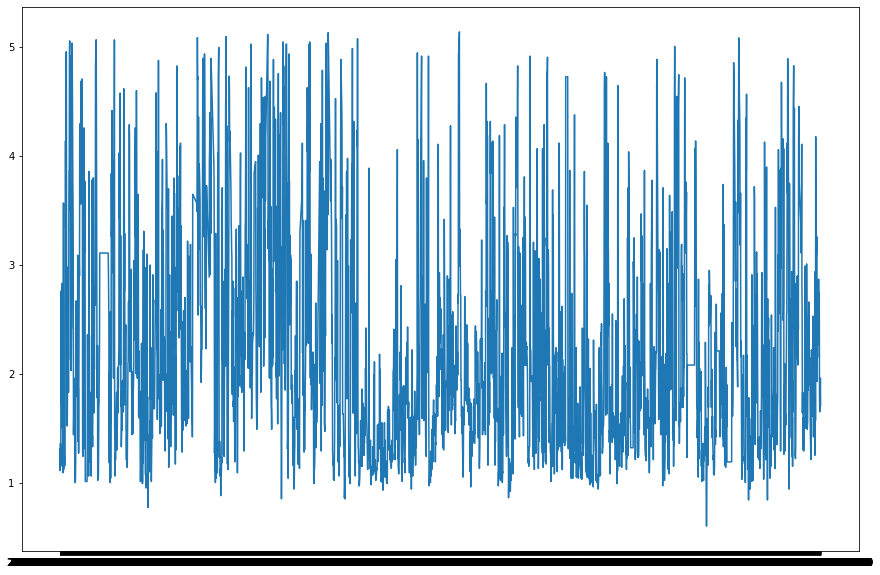

In [ ]:
plt.figure(figsize = (15, 10))
plt.plot(org["date"], org["% Silica Concentrate"])
plt.show();

Purity
0     771
1    2651
dtype: int64


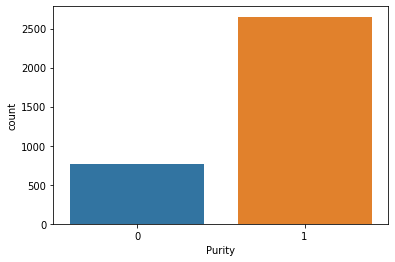

In [ ]:
import seaborn as sns

df = pd.read_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/chosen_dataset_xgboost.csv')

df.dropna(inplace = True)

df["date"] = pd.to_datetime(df["date"])

df.insert(0,'new_date',df['date'].dt.strftime("%Y%m%d%H%M%S").astype(int))
df.drop('date', axis=1, inplace=True)

print(df.groupby(['Purity']).size())

# define dataset
X = df.drop(['Purity'], axis=1)
y = df['Purity']

sns.countplot(x ='Purity', data = df);

##  **Smote**

Before smote:  3422
Counter({1: 2651, 0: 771})
Counter({1: 2651, 0: 2651})
After smote :  5302


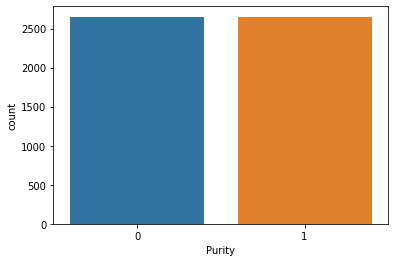

In [ ]:
## Implementing smote method

from collections import Counter
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot

print('Before smote: ',len(X))

counter = Counter(y)
print(counter)

oversample = SMOTE()
X_res, y_res = oversample.fit_resample(X, y)

counter = Counter(y_res)
print(counter)

print('After smote : ',len(X_res))

smote_df = pd.concat([X_res, y_res], axis=1)
sns.countplot(x ='Purity', data = smote_df);

##  **Smote & TomerLinks**

Original dataset shape Counter({1: 2651, 0: 2651})
Resampled dataset shape Counter({0: 2651, 1: 2424})
Purity
0    2651
1    2424
dtype: int64


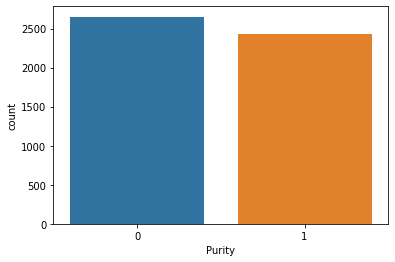

In [ ]:
from imblearn.under_sampling import TomekLinks 

X = smote_df.drop(['Purity'], axis=1)
y = smote_df['Purity']

print('Original dataset shape %s' % Counter(y))

tl = TomekLinks()
X_res, y_res = tl.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

smote_tl_df = pd.concat([X_res, y_res], axis=1)
print(smote_tl_df.groupby(['Purity']).size())

sns.countplot(x ='Purity', data = smote_tl_df);

##  **Smote & ENN** 

Original dataset shape Counter({1: 2651, 0: 2651})
Resampled dataset shape Counter({0: 2651, 1: 1894})
Purity
0    2651
1    1894
dtype: int64


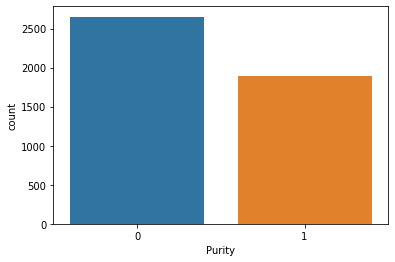

In [ ]:
from imblearn.under_sampling import EditedNearestNeighbours 

X = smote_df.drop(['Purity'], axis=1)
y = smote_df['Purity']

print('Original dataset shape %s' % Counter(y))

#n_neighbors = 3
enn = EditedNearestNeighbours()
X_res, y_res = enn.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

smote_enn_df = pd.concat([X_res, y_res], axis=1)
print(smote_enn_df.groupby(['Purity']).size())

sns.countplot(x ='Purity', data = smote_enn_df);

##  **Smote-SVM**

Original dataset shape Counter({1: 2651, 0: 771})
Resampled dataset shape Counter({1: 2651, 0: 2651})
Purity
0    2651
1    2651
dtype: int64


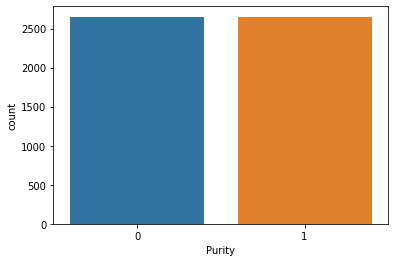

In [ ]:
from collections import Counter
from imblearn.over_sampling import SVMSMOTE 

X = df.drop(['Purity'], axis=1)
y = df['Purity']

print('Original dataset shape %s' % Counter(y))

sm = SVMSMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

smote_svm_df = pd.concat([X_res, y_res], axis=1)
print(smote_svm_df.groupby(['Purity']).size())

sns.countplot(x ='Purity', data = smote_svm_df);

##  **Smote-SVM & TomerLinks**

Original dataset shape Counter({1: 2651, 0: 2651})
Resampled dataset shape Counter({0: 2651, 1: 2448})
Purity
0    2651
1    2448
dtype: int64


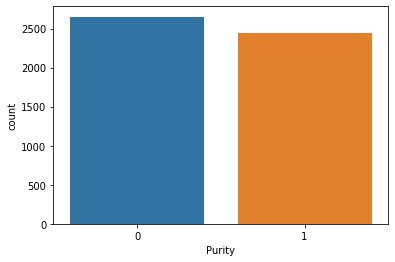

In [ ]:
from imblearn.under_sampling import TomekLinks 

X = smote_svm_df.drop(['Purity'], axis=1)
y = smote_svm_df['Purity']

print('Original dataset shape %s' % Counter(y))

tl = TomekLinks()
X_res, y_res = tl.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

smote_svm_tl_df = pd.concat([X_res, y_res], axis=1)
print(smote_svm_tl_df.groupby(['Purity']).size())

sns.countplot(x ='Purity', data = smote_svm_tl_df);

##  **Smote-SVM & ENN**

Original dataset shape Counter({1: 2651, 0: 2651})
Resampled dataset shape Counter({0: 2651, 1: 1932})
Purity
0    2651
1    1932
dtype: int64


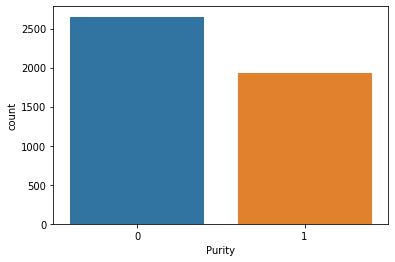

In [ ]:
from imblearn.under_sampling import EditedNearestNeighbours 

X = smote_svm_df.drop(['Purity'], axis=1)
y = smote_svm_df['Purity']

print('Original dataset shape %s' % Counter(y))

#n_neighbors = 3
enn = EditedNearestNeighbours()
X_res, y_res = enn.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

smote_svm_enn_df = pd.concat([X_res, y_res], axis=1)
print(smote_svm_enn_df.groupby(['Purity']).size())

sns.countplot(x ='Purity', data = smote_svm_enn_df);

In [ ]:
all_dfs = [df, smote_tl_df, smote_enn_df, smote_svm_tl_df, smote_svm_enn_df]

## KNN classification

Purity
0     771
1    2651
dtype: int64
1 96.3785046728972
_______________________________________________
Purity
0    2651
1    2424
dtype: int64
2 98.26635145784081
_______________________________________________
Purity
0    2651
1    1894
dtype: int64
3 99.56024626209323
_______________________________________________
Purity
0    2651
1    2448
dtype: int64
4 97.5686274509804
_______________________________________________
Purity
0    2651
1    1932
dtype: int64
5 99.30191972076788
_______________________________________________
{'dataset': 3, 'accuracy': 99.56024626209323, 'best_params': ['manhattan', 3, 'distance']}
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       667
           1       1.00      0.99      0.99       479

    accuracy                           0.99      1146
   macro avg       0.99      0.99      0.99      1146
weighted avg       0.99      0.99      0.99      1146



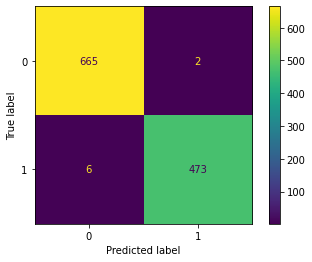

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve

#initialisation
best_params = 0
i = 0

for df in all_dfs:
  print(df.groupby(['Purity']).size())
  i = i + 1
  X = df.drop(['Purity'], axis=1)
  y = df['Purity']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

  mms = MinMaxScaler()
  X_train = mms.fit_transform(X_train)
  X_test = mms.transform(X_test)

  grid_params = {
      'n_neighbors' : [3,5,11,19], # Always odd numbers to avaid ties
      'weights': ['uniform', 'distance'],
      'metric': ['euclidean', 'manhattan']
  }

  grid = GridSearchCV(
      KNeighborsClassifier(),
      grid_params,
      cv = 5,
      n_jobs = -1 #use all resources
  )

  grid_results = grid.fit(X_train, y_train)
  best_params = [grid_results.best_params_['metric'],grid_results.best_params_['n_neighbors'],grid_results.best_params_['weights']]

  #KNN with the best params
  model = KNeighborsClassifier(n_neighbors=best_params[1], 
                            weights=best_params[2], 
                            metric=best_params[0], 
                            n_jobs=-1)
  model.fit(X_train, y_train)
  y_test_hat=model.predict(X_test) 
  test_accuracy=accuracy_score(y_test,y_test_hat)*100
  if accuracy  < test_accuracy:
    accuracy = test_accuracy
    max = { 'dataset': i, 'accuracy': accuracy, 'best_params': best_params }
  print(i,test_accuracy)
  print('_______________________________________________')

print(max)

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);  
y_pred = model.predict(X_test)

print(classification_report(y_test,y_pred))

0.9570025863105979


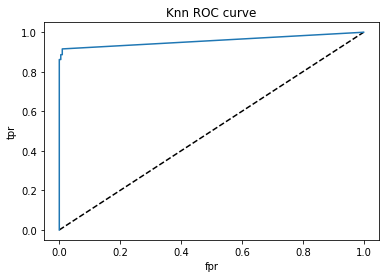

0.9669157792448483


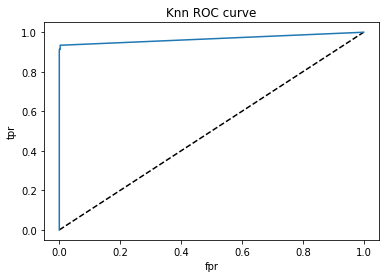

0.9932931677580756


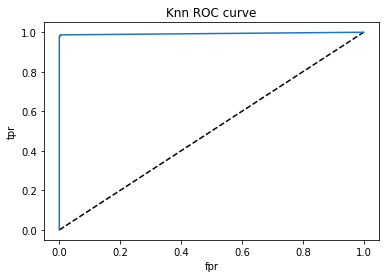

0.9892854679463178


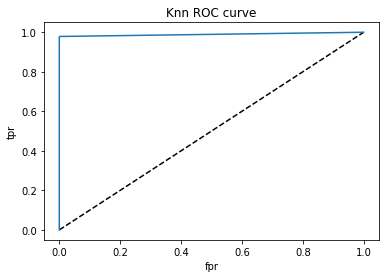

0.9957244759666095


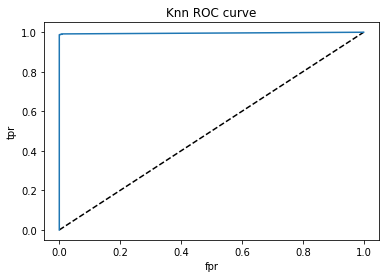

In [ ]:
#Area under ROC curve
from sklearn.metrics import roc_auc_score

for df in all_dfs:
  i = i + 1
  X = df.drop(['Purity'], axis=1)
  y = df['Purity']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

  mms = MinMaxScaler()
  X_train = mms.fit_transform(X_train)
  X_test = mms.transform(X_test)

  y_pred_proba = model.predict_proba(X_test)[:,1]
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

  print(roc_auc_score(y_test,y_pred_proba))

  plt.plot([0,1],[0,1],'k--')
  plt.plot(fpr,tpr, label='Knn')
  plt.xlabel('fpr')
  plt.ylabel('tpr')
  plt.title('Knn ROC curve')
  plt.show()


# ROC scores
**Original df:** 0.9529840310357273 <br>
**SMOTE + Tomer links df:** 0.9722907817029707 <br>
**SMOTE + ENN df:** 0.9971468279921517 ✅ <br> 
**SMOTESVM + Tomer links df:** 0.9844650963072015 <br>
**SMOTESVM + ENN df:** 0.9954855012172198

In [ ]:
smote_enn_df['dates'] = pd.to_datetime(smote_enn_df['new_date'], format='%Y%m%d%H%M%S%f')
smote_enn_df.drop('new_date', axis=1, inplace=True)

smote_enn_df

,% Silica Feed,Amina Flow,Flotation Column 01 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 02 Level,Flotation Column 03 Level,% Iron Concentrate,% Silica Concentrate,Purity,dates
0,17.16,525.485894,249.713067,250.063072,295.096000,549.616767,549.614561,66.21,3.57,0,2017-03-10 18:00:00
1,8.25,331.547060,249.555854,249.593788,295.096000,552.302199,550.595146,65.12,4.14,0,2017-03-11 03:00:00
2,8.25,319.234130,250.036586,250.042059,295.096000,549.753047,550.000929,64.26,3.34,0,2017-03-11 04:00:00
3,8.25,330.744316,249.910807,249.956708,295.096000,549.746129,550.522895,64.08,4.08,0,2017-03-11 05:00:00
4,8.98,363.725733,249.986304,250.116259,295.096000,561.392236,557.172677,63.33,4.96,0,2017-03-11 07:00:00
...,...,...,...,...,...,...,...,...,...,...,...
4540,23.20,498.785884,301.432594,299.756449,299.929000,497.870623,409.189681,65.05,1.65,1,2017-09-09 19:00:00
4541,23.20,510.780566,300.181000,299.593867,299.526313,498.402434,392.437663,64.83,1.71,1,2017-09-09 20:00:00
4542,23.20,519.289535,299.419465,299.995958,299.767268,500.891915,459.091225,64.29,1.80,1,2017-09-09 21:00:00
4543,23.20,493.451375,299.738536,299.809750,299.995732,494.662857,830.694840,64.25,1.96,1,2017-09-09 22:00:00


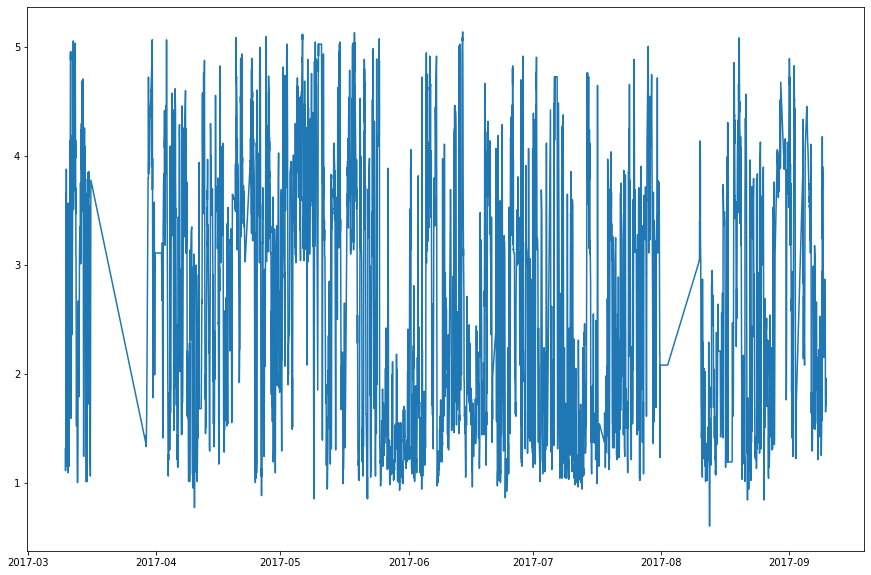

In [ ]:
plt.figure(figsize = (15, 10))
smote_enn_df = smote_enn_df.sort_values(by="dates")
plt.plot(smote_enn_df["dates"], smote_enn_df["% Silica Concentrate"])
plt.show();

In [ ]:
smote_enn_df.to_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/dataset_xgboost_smote_enn.csv', index=False)